In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from preprocessing.tokenize_qwen import load_qwen_tokenizer, tokenize_df, expand_chunked_df

/opt/anaconda3/envs/InsureHub/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
# 1. Load your JSONL file
data = "data/training_datasets/verified_GPThybrid.jsonl"
hybrid_df = pd.read_json(data, lines=True)
nocomment_df = pd.read_json("data/training_datasets/verified_nocomments.jsonl", lines=True)
nomod_df = pd.read_json("data/training_datasets/verified_nomods.jsonl", lines=True)
metrics_df = pd.read_csv("data/training_datasets/metrics.csv")
syntax_df = pd.read_json("data/training_datasets/syntax_check/GPThybrid.jsonl", lines=True)
# Keep only files that passed syntax check
hybrid_df = hybrid_df[hybrid_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
nocomment_df = nocomment_df[nocomment_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
nomod_df = nomod_df[nomod_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
metrics_df = metrics_df[metrics_df["filename"].isin(syntax_df.where(syntax_df["load_ok"] == True)["filename"])].reset_index(drop=True).copy()
# 2. Load tokenizer
tokenizer = load_qwen_tokenizer("Qwen/Qwen2.5-Coder-14B")

# 3. Tokenize
hybrid_tok_df = tokenize_df(hybrid_df, tokenizer)
nocomment_tok_df = tokenize_df(nocomment_df, tokenizer)
nomod_tok_df = tokenize_df(nomod_df, tokenizer)

metrics_df = metrics_df.merge(hybrid_tok_df[["filename", "n_tokens"]], on="filename", how="left")
metrics_df = metrics_df.rename(columns={"n_tokens": "hybrid_tokens"})
metrics_df = metrics_df.merge(nocomment_tok_df[["filename", "n_tokens"]], on="filename", how="left")
metrics_df = metrics_df.rename(columns={"n_tokens": "nocomment_tokens"})
metrics_df = metrics_df.merge(nomod_tok_df[["filename", "n_tokens"]], on="filename", how="left")
metrics_df = metrics_df.rename(columns={"n_tokens": "nomod_tokens"})



#print(hybrid_tok_df[["filename", "n_tokens"]].head())

# 4. Optional: Chunk for training
hybrid_chunk_df = expand_chunked_df(hybrid_tok_df, tokenizer, max_seq_len=4096, stride=256)
nocomment_chunk_df = expand_chunked_df(nocomment_tok_df, tokenizer, max_seq_len=4096, stride=256)
nomod_chunk_df = expand_chunked_df(nomod_tok_df, tokenizer, max_seq_len=4096, stride=256)
hybrid_chunk_df.head()



Token indices sequence length is longer than the specified maximum sequence length for this model (77160 > 32768). Running this sequence through the model will result in indexing errors


,filename,chunk_index,input_ids,n_tokens
0,cryptol/examples/splitAt.cry,0,"[87, 284, 508, 16, 11, 17, 11, 18, 11, 19, 60,...",69
1,cryptol/examples/AE.cry,0,"[3284, 36850, 315, 279, 25185, 504, 279, 5567,...",728
2,cryptol/examples/xor_cipher.cry,0,"[32826, 549, 314, 64, 25547, 5472, 264, 8, 589...",89
3,cryptol/examples/zero_weird.cry,0,"[87, 549, 314, 64, 92, 368, 589, 264, 1464, 50...",83
4,cryptol/examples/builtin_lifting.cry,0,"[322, 46239, 1330, 11893, 916, 45225, 11, 1298...",399


In [3]:
hybrid_tok_df.head()

,filename,filetype,content,variant,input_ids,n_tokens
0,cryptol/examples/splitAt.cry,cry,"x = [1,2,3,4] : [_][8]\n\ny = (splitAt x) : ([...",hybrid,"[87, 284, 508, 16, 11, 17, 11, 18, 11, 19, 60,...",69
1,cryptol/examples/AE.cry,cry,/*\nImplementation of the algorithms from the ...,hybrid,"[3284, 36850, 315, 279, 25185, 504, 279, 5567,...",728
2,cryptol/examples/xor_cipher.cry,cry,encrypt : {a}(fin a) => [8] -> [a][8] -> [a][8...,hybrid,"[32826, 549, 314, 64, 25547, 5472, 264, 8, 589...",89
3,cryptol/examples/zero_weird.cry,cry,x : {a}() => a -> [16]\nx v = zero v \n\nprope...,hybrid,"[87, 549, 314, 64, 92, 368, 589, 264, 1464, 50...",83
4,cryptol/examples/builtin_lifting.cry,cry,"//builtins lift over tuples, seqs, and records...",hybrid,"[322, 46239, 1330, 11893, 916, 45225, 11, 1298...",399


In [4]:
print(hybrid_chunk_df["n_tokens"].sum())
metrics_df.head()

773720


,filename,sha1,bytes,lines,avg_line_len,max_line_len,non_ascii_ratio,binary_like,enc_total_matched,enc_max_run,...,k_shingle,num_shingles,hexnum_ratio,num_tokens_model,junk_path,quality_ok,fail_reason,hybrid_tokens,nocomment_tokens,nomod_tokens
0,cryptol/examples/splitAt.cry,816e7cd6994a469bc9fb88ded8fea4f463a59e40,108,10,9.90,33,0.0,False,0,0,...,5,64,0.0,NaN,True,True,ok,69,69,69
1,cryptol/examples/AE.cry,05483796c6a8a4760cd335120b09c67c7ef1db78,2372,86,26.59,77,0.0,False,0,0,...,5,442,0.0,NaN,True,True,ok,728,490,759
2,cryptol/examples/xor_cipher.cry,e0f950dcd057b865153df435205bb95decfde4e0,264,7,36.86,56,0.0,False,0,0,...,5,92,0.0,NaN,True,True,ok,89,89,89
3,cryptol/examples/zero_weird.cry,d9a57173f1d3d0e9177212dba96b6e625a154551,163,13,11.62,31,0.0,False,0,0,...,5,62,0.0,NaN,True,True,ok,83,83,83
4,cryptol/examples/builtin_lifting.cry,c491ba67bacc44f7be36b518a183ea8a89279c4b,1133,49,22.14,93,0.0,False,0,0,...,5,280,0.0,NaN,True,True,ok,399,286,399


In [5]:
combined_df = pd.concat([
    nomod_tok_df.assign(source="All Comments"),
    hybrid_tok_df.assign(source="Hybrid"),
    nocomment_tok_df.assign(source="No Comments")
])


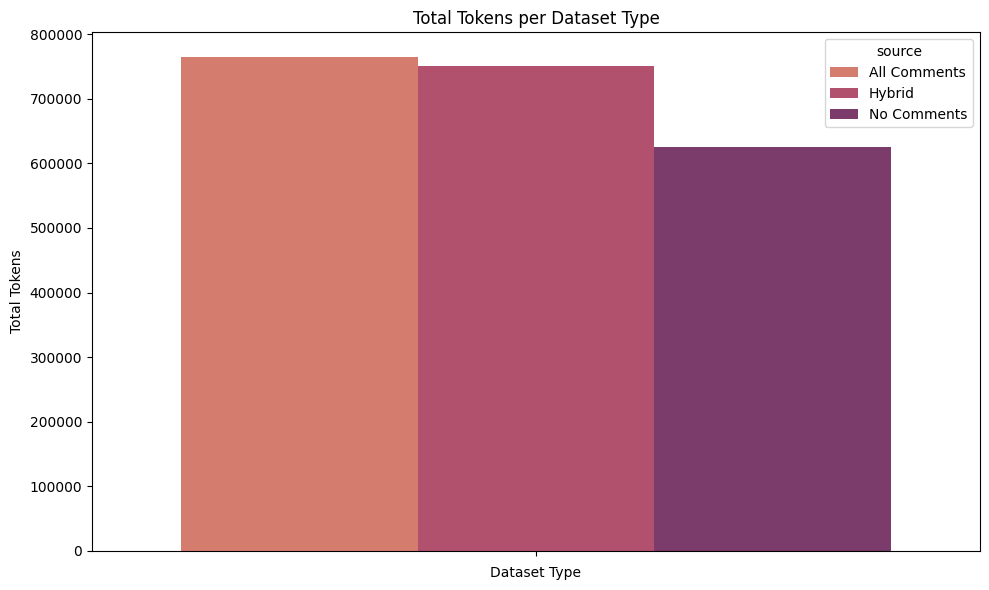

         source  n_tokens
0  All Comments    764804
1        Hybrid    751192
2   No Comments    624732


In [6]:
plt.figure(figsize=(10,6))
sns.barplot(data=combined_df.groupby("source")["n_tokens"].sum().reset_index(), hue="source", y="n_tokens", palette="flare", legend=True)
plt.title("Total Tokens per Dataset Type")
plt.ylabel("Total Tokens")
plt.xlabel("Dataset Type")
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
print(combined_df.groupby("source")["n_tokens"].sum().reset_index())

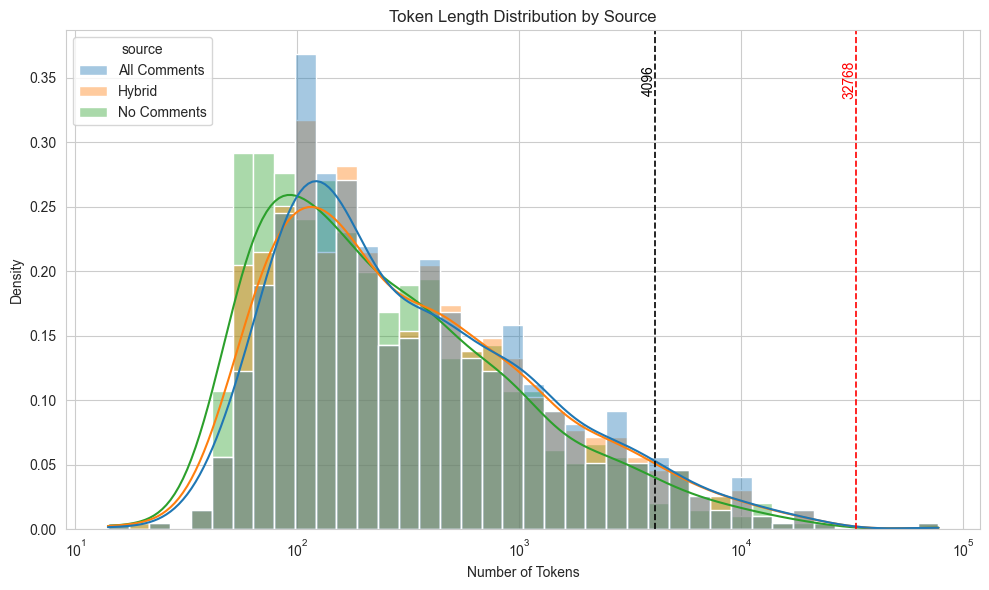

In [7]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10,6))
sns.histplot(data=combined_df, x="n_tokens", hue="source", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
# Add dashed vertical lines
plt.axvline(x=4096, color="black", linestyle="--", linewidth=1.2)
plt.axvline(x=32768, color="red", linestyle="--", linewidth=1.2)

# Add text labels near the lines
plt.text(4096, plt.ylim()[1]*0.9, "4096", color="black", fontsize=10, ha="right", va="center", rotation=90)
plt.text(32768, plt.ylim()[1]*0.9, "32768", color="red", fontsize=10, ha="right", va="center", rotation=90)
plt.title("Token Length Distribution by Source")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [8]:
text_df = pd.read_json("data/training_datasets/cleaned_text_data.jsonl", lines=True)
text_tok_df = tokenize_df(text_df, tokenizer)
print(text_tok_df["n_tokens"].sum())
text_tok_df.head()

71691


,filename,filetype,content,input_ids,n_tokens
0,https_saw.galois.com_intro_IntroToSAW.html.txt,txt,```markdown\n## First Example: Counting Set Bi...,"[73594, 60073, 198, 565, 5512, 13383, 25, 4504...",4202
1,https_saw.galois.com_intro_Pointers.html.txt,txt,```markdown\n## Specifying Memory Layout\n\nPr...,"[73594, 60073, 198, 565, 10956, 7766, 13850, 1...",2350
2,https_saw.galois.com_intro_Salsa20.html.txt,txt,```markdown\n## Compositional Verification and...,"[73594, 60073, 198, 565, 1198, 966, 3005, 5547...",5284
3,https_saw.galois.com_intro_HMACProblem.html.txt,txt,```markdown\n## Proof Maintenance Exercises: s...,"[73594, 60073, 198, 565, 36991, 38206, 90454, ...",2656
4,https_saw.galois.com_intro_HMACSolution.html.txt,txt,```markdown\n## Proof Maintenance Exercises: S...,"[73594, 60073, 198, 565, 36991, 38206, 90454, ...",3482


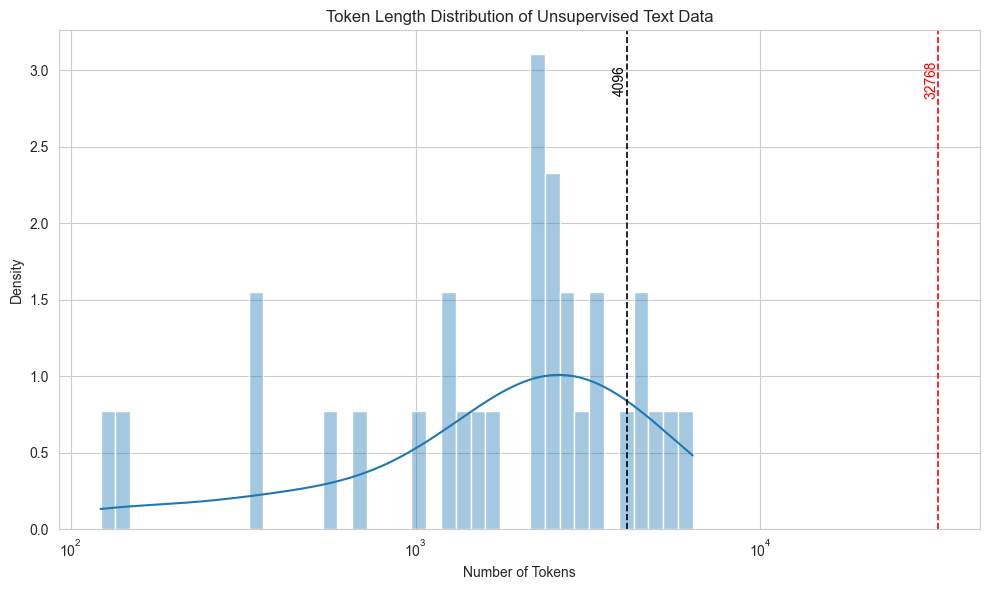

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(data=text_tok_df, x="n_tokens", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
# Add dashed vertical lines
plt.axvline(x=4096, color="black", linestyle="--", linewidth=1.2)
plt.axvline(x=32768, color="red", linestyle="--", linewidth=1.2)

# Add text labels near the lines
plt.text(4096, plt.ylim()[1]*0.9, "4096", color="black", fontsize=10, ha="right", va="center", rotation=90)
plt.text(32768, plt.ylim()[1]*0.9, "32768", color="red", fontsize=10, ha="right", va="center", rotation=90)
plt.title("Token Length Distribution of Unsupervised Text Data")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

nocomment_df.head()



,filename,filetype,content,variant
0,cryptol/examples/splitAt.cry,cry,"x = [1,2,3,4] : [_][8]\n\ny = (splitAt x) : ([...",without_comments
1,cryptol/examples/AE.cry,cry,module AE where\n\nparameter\n type A : * ...,without_comments
2,cryptol/examples/xor_cipher.cry,cry,encrypt : {a}(fin a) => [8] -> [a][8] -> [a][8...,without_comments
3,cryptol/examples/zero_weird.cry,cry,x : {a}() => a -> [16]\nx v = zero v \n\nprope...,without_comments
4,cryptol/examples/builtin_lifting.cry,cry,"x = [True,False]\ny = [False,True]\n\nproperty...",without_comments


In [11]:
filenames = nocomment_df["filename"].unique().tolist()
val_size = 20 / 30
unsupervised_filenames, temp = train_test_split(filenames, test_size=0.3, random_state=42)
supervised_filenames, holdout_filenames = train_test_split(temp, test_size=1 - val_size, random_state=42)
print(f"Unsupervised: {len(unsupervised_filenames)} files"
      f", Supervised: {len(supervised_filenames)} files"
      f", Holdout: {len(holdout_filenames)} files")

Unsupervised: 487 files, Supervised: 139 files, Holdout: 71 files


In [12]:
hybrid_tok_df["set"] = ""
hybrid_tok_df.loc[hybrid_tok_df["filename"].isin(unsupervised_filenames), "set"] = "unsupervised"
hybrid_tok_df.loc[hybrid_tok_df["filename"].isin(supervised_filenames), "set"] = "supervised"
hybrid_tok_df.loc[hybrid_tok_df["filename"].isin(holdout_filenames), "set"] = "holdout"
hybrid_tok_df.head()

,filename,filetype,content,variant,input_ids,n_tokens,set
0,cryptol/examples/splitAt.cry,cry,"x = [1,2,3,4] : [_][8]\n\ny = (splitAt x) : ([...",hybrid,"[87, 284, 508, 16, 11, 17, 11, 18, 11, 19, 60,...",69,unsupervised
1,cryptol/examples/AE.cry,cry,/*\nImplementation of the algorithms from the ...,hybrid,"[3284, 36850, 315, 279, 25185, 504, 279, 5567,...",728,unsupervised
2,cryptol/examples/xor_cipher.cry,cry,encrypt : {a}(fin a) => [8] -> [a][8] -> [a][8...,hybrid,"[32826, 549, 314, 64, 25547, 5472, 264, 8, 589...",89,supervised
3,cryptol/examples/zero_weird.cry,cry,x : {a}() => a -> [16]\nx v = zero v \n\nprope...,hybrid,"[87, 549, 314, 64, 92, 368, 589, 264, 1464, 50...",83,unsupervised
4,cryptol/examples/builtin_lifting.cry,cry,"//builtins lift over tuples, seqs, and records...",hybrid,"[322, 46239, 1330, 11893, 916, 45225, 11, 1298...",399,unsupervised


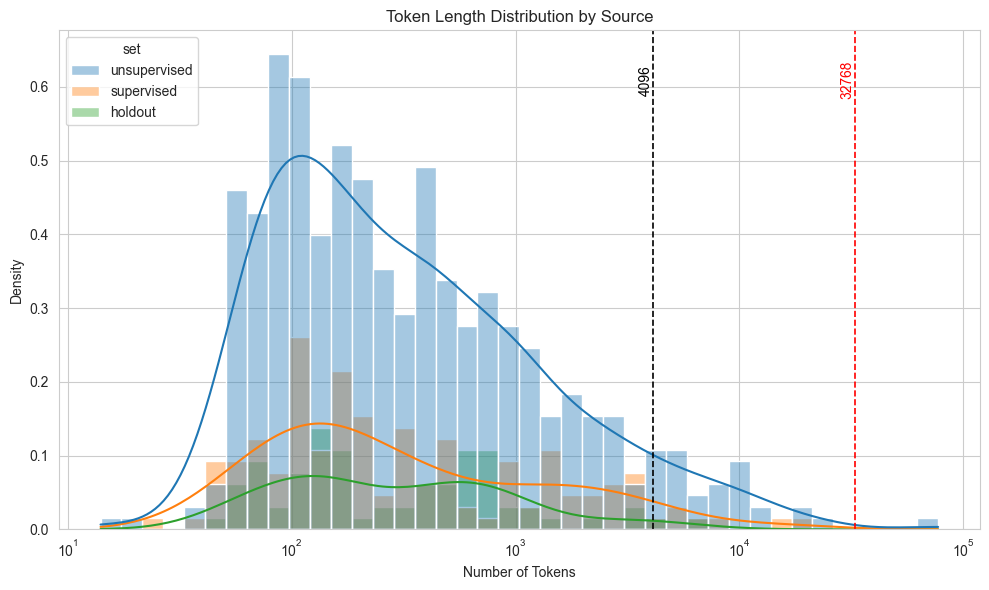

In [13]:
sns.set_style("whitegrid") 
plt.figure(figsize=(10,6))
sns.histplot(data=hybrid_tok_df, x="n_tokens", hue="set", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
# Add dashed vertical lines
plt.axvline(x=4096, color="black", linestyle="--", linewidth=1.2)
plt.axvline(x=32768, color="red", linestyle="--", linewidth=1.2)

# Add text labels near the lines
plt.text(4096, plt.ylim()[1]*0.9, "4096", color="black", fontsize=10, ha="right", va="center", rotation=90)
plt.text(32768, plt.ylim()[1]*0.9, "32768", color="red", fontsize=10, ha="right", va="center", rotation=90)
plt.title("Token Length Distribution by Source")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

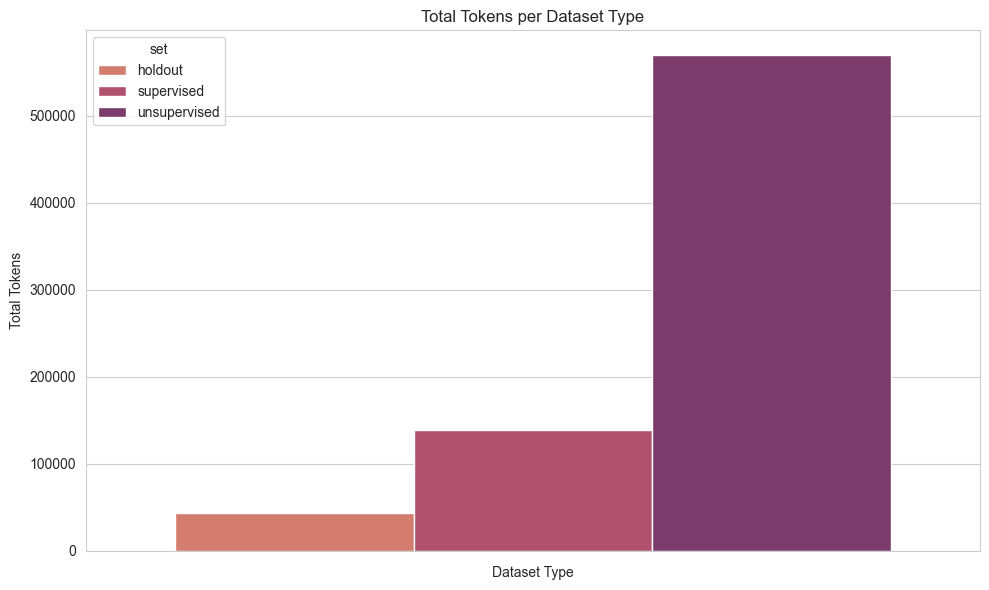

            set  n_tokens
0       holdout     42862
1    supervised    138403
2  unsupervised    569927
Percentages: 
            set   n_tokens
0       holdout   5.705865
1    supervised  18.424451
2  unsupervised  75.869684 


In [14]:
plt.figure(figsize=(10,6))
sns.barplot(data=hybrid_tok_df.groupby("set")["n_tokens"].sum().reset_index(), hue="set", y="n_tokens", palette="flare", legend=True)
plt.title("Total Tokens per Dataset Type")
plt.ylabel("Total Tokens")
plt.xlabel("Dataset Type")
#plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
total_tokens = hybrid_tok_df['n_tokens'].sum()
print(hybrid_tok_df.groupby("set")["n_tokens"].sum().reset_index())
print(f"Percentages: \n{(hybrid_tok_df.groupby('set')['n_tokens'].sum() / total_tokens * 100).reset_index()} ")


In [15]:
text_names = text_df["filename"].unique().tolist()
unsupervised_filenames, _temp = train_test_split(text_names, test_size=0.15, random_state=42)
validation_filenames, holdout_filenames = train_test_split(_temp, test_size=0.5, random_state=42)

print(f"Unsupervised: {len(unsupervised_filenames)} files"
      f", Validation: {len(validation_filenames)} files"
      f", Holdout: {len(holdout_filenames)} files")


Unsupervised: 25 files, Validation: 2 files, Holdout: 3 files


In [16]:
text_tok_df["set"] = ""
text_tok_df.loc[text_tok_df["filename"].isin(unsupervised_filenames), "set"] = "unsupervised"
text_tok_df.loc[text_tok_df["filename"].isin(validation_filenames), "set"] = "validation"
text_tok_df.loc[text_tok_df["filename"].isin(holdout_filenames), "set"] = "holdout"
text_tok_df.head()

,filename,filetype,content,input_ids,n_tokens,set
0,https_saw.galois.com_intro_IntroToSAW.html.txt,txt,```markdown\n## First Example: Counting Set Bi...,"[73594, 60073, 198, 565, 5512, 13383, 25, 4504...",4202,unsupervised
1,https_saw.galois.com_intro_Pointers.html.txt,txt,```markdown\n## Specifying Memory Layout\n\nPr...,"[73594, 60073, 198, 565, 10956, 7766, 13850, 1...",2350,unsupervised
2,https_saw.galois.com_intro_Salsa20.html.txt,txt,```markdown\n## Compositional Verification and...,"[73594, 60073, 198, 565, 1198, 966, 3005, 5547...",5284,unsupervised
3,https_saw.galois.com_intro_HMACProblem.html.txt,txt,```markdown\n## Proof Maintenance Exercises: s...,"[73594, 60073, 198, 565, 36991, 38206, 90454, ...",2656,unsupervised
4,https_saw.galois.com_intro_HMACSolution.html.txt,txt,```markdown\n## Proof Maintenance Exercises: S...,"[73594, 60073, 198, 565, 36991, 38206, 90454, ...",3482,unsupervised


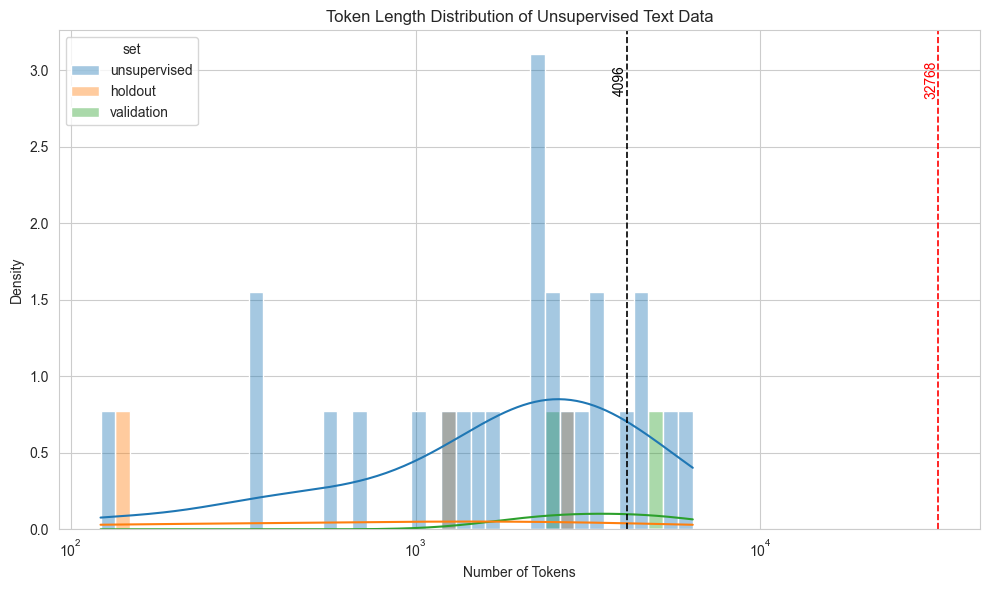

In [17]:
plt.figure(figsize=(10,6))
sns.histplot(data=text_tok_df, x="n_tokens", hue="set", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
# Add dashed vertical lines
plt.axvline(x=4096, color="black", linestyle="--", linewidth=1.2)
plt.axvline(x=32768, color="red", linestyle="--", linewidth=1.2)

# Add text labels near the lines
plt.text(4096, plt.ylim()[1]*0.9, "4096", color="black", fontsize=10, ha="right", va="center", rotation=90)
plt.text(32768, plt.ylim()[1]*0.9, "32768", color="red", fontsize=10, ha="right", va="center", rotation=90)
plt.title("Token Length Distribution of Unsupervised Text Data")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [18]:
text_total_tokens = text_tok_df['n_tokens'].sum()
print(text_tok_df.groupby("set")["n_tokens"].sum().reset_index())
print(f"Percentages: \n{(text_tok_df.groupby('set')['n_tokens'].sum() / text_total_tokens * 100).reset_index()} ")

            set  n_tokens
0       holdout      4109
1  unsupervised     60237
2    validation      7345
Percentages: 
            set   n_tokens
0       holdout   5.731542
1  unsupervised  84.023099
2    validation  10.245359 


In [19]:
unsupervised_hybrid_df = hybrid_tok_df[hybrid_tok_df["set"] == "unsupervised"].copy()
text_tok_df["variant"] = "formatted_text"
unsupervised_hybrid_df = pd.concat([unsupervised_hybrid_df, text_tok_df[text_tok_df["set"] == "unsupervised"]], ignore_index=True)
unsupervised_hybrid_df.head()

,filename,filetype,content,variant,input_ids,n_tokens,set
0,cryptol/examples/splitAt.cry,cry,"x = [1,2,3,4] : [_][8]\n\ny = (splitAt x) : ([...",hybrid,"[87, 284, 508, 16, 11, 17, 11, 18, 11, 19, 60,...",69,unsupervised
1,cryptol/examples/AE.cry,cry,/*\nImplementation of the algorithms from the ...,hybrid,"[3284, 36850, 315, 279, 25185, 504, 279, 5567,...",728,unsupervised
2,cryptol/examples/zero_weird.cry,cry,x : {a}() => a -> [16]\nx v = zero v \n\nprope...,hybrid,"[87, 549, 314, 64, 92, 368, 589, 264, 1464, 50...",83,unsupervised
3,cryptol/examples/builtin_lifting.cry,cry,"//builtins lift over tuples, seqs, and records...",hybrid,"[322, 46239, 1330, 11893, 916, 45225, 11, 1298...",399,unsupervised
4,cryptol/examples/inflist.cry,cry,"a = [1 ... ]\nb = [1,2 ... ]\nc = [1 .. 5]\nd ...",hybrid,"[64, 284, 508, 16, 2503, 5133, 65, 284, 508, 1...",80,unsupervised


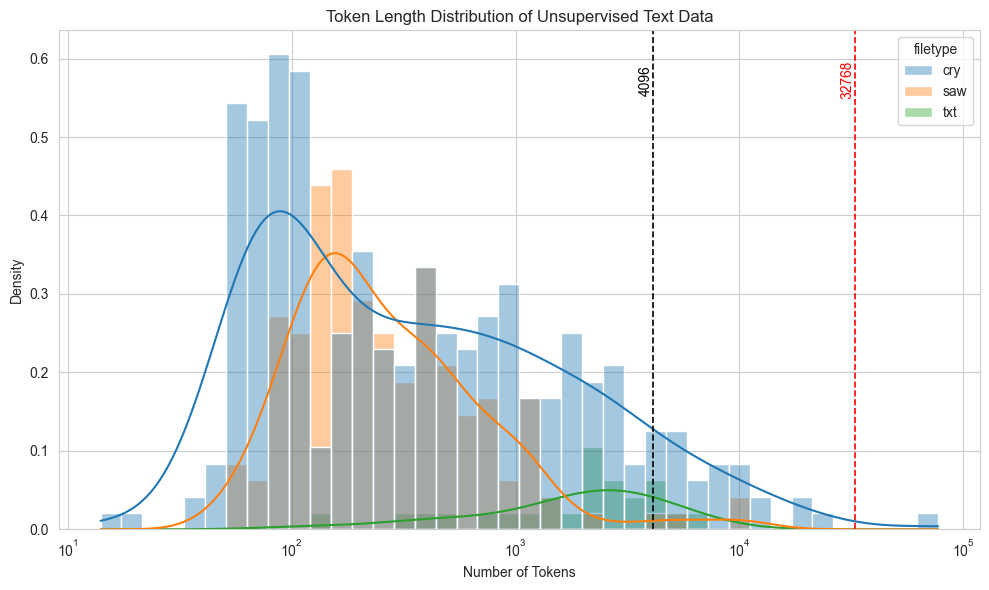

In [20]:
plt.figure(figsize=(10,6))
sns.histplot(data=unsupervised_hybrid_df, x="n_tokens", hue="filetype", kde=True, bins=40, alpha=0.4, log_scale=True, stat="density")
# Add dashed vertical lines
plt.axvline(x=4096, color="black", linestyle="--", linewidth=1.2)
plt.axvline(x=32768, color="red", linestyle="--", linewidth=1.2)

# Add text labels near the lines
plt.text(4096, plt.ylim()[1]*0.9, "4096", color="black", fontsize=10, ha="right", va="center", rotation=90)
plt.text(32768, plt.ylim()[1]*0.9, "32768", color="red", fontsize=10, ha="right", va="center", rotation=90)
plt.title("Token Length Distribution of Unsupervised Text Data")
plt.xlabel("Number of Tokens")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [22]:
unsupervised_hybrid_df["n_tokens"].sum()
unsupervised_hybrid_df.to_json("data/unsupervised/unsupervised_hybrid_data.jsonl", lines=True, orient="records")